In [64]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
# py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold


from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve


# Feature Exploration, Engineering and Cleaning 

Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
# Load in the train and test datasets
train = pd.read_csv("./input/titanic/train.csv")
test = pd.read_csv("./input/titanic/test.csv")

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
full_data = [train, test]

In [4]:
train_len = len(train)
dataset_join =  pd.concat(objs=[train, test], axis=0, sort=True).reset_index(drop=True)


In [5]:
dataset_join = dataset_join.fillna(np.nan)

dataset_join.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [6]:
dataset_join["Fare"].isnull().sum()

1

In [7]:
dataset_join['Fare'] = dataset_join['Fare'].fillna(dataset_join['Fare'].median())
dataset_join["Fare"] = dataset_join["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [8]:
dataset_join["Embarked"].isnull().sum()

2

In [9]:
dataset_join['Embarked'] = dataset_join['Embarked'].fillna('C')

In [10]:
index_NaN_Em = dataset_join[dataset_join['Embarked'].isnull()].index.tolist()

In [11]:
index_NaN_Em

[]

In [12]:
dataset_join['Pclass'][829]
# PClass 1 -> Embarked Median C

1

In [13]:
# dataset_join[dataset_join['Age'].isnull()].index.tolist()

In [14]:
index_NaN_age = dataset_join[dataset_join['Age'].isnull()].index.tolist()

In [15]:
for age_index in index_NaN_age:
    age_med = dataset_join['Age'].median()
    age_pred = dataset_join['Age'][
        ((dataset_join['SibSp'] == dataset_join.iloc[age_index]["SibSp"]) & 
        (dataset_join['Parch'] == dataset_join.iloc[age_index]["Parch"]) & 
        (dataset_join['Pclass'] == dataset_join.iloc[age_index]["Pclass"]))
    ].median()
    if np.isnan(age_pred):
        print('age_pred', age_pred)
        dataset_join['Age'].iloc[age_index] = age_med
    else :
        dataset_join['Age'].iloc[age_index] = age_pred

age_pred nan


In [16]:
dataset_join_title = [i.split(",")[1].split(".")[0].strip() for i in dataset_join["Name"]]
dataset_join['Title'] = pd.Series(dataset_join_title)
dataset_join['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [17]:
# Convert to categorical values Title 
dataset_join["Title"] = dataset_join["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Rev', 'Jonkheer'], 'Rare')
dataset_join["Title"] = dataset_join["Title"].map({"Master":0, "Sir":2, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Capt":2, "Major":2, "Mr":2, "Dr":2, 'Dona':1, "Rare":3})
dataset_join["Title"] = dataset_join["Title"].astype(int)

In [18]:
dataset_join['Name_length'] = dataset_join['Name'].apply(len)

In [19]:
# dataset_join['Has_Cabin'] = dataset_join['Cabin'].apply(
#     lambda x:0 if type(x) == float else 1)

In [20]:
# g = sns.catplot(x="Has_Cabin",y="Survived",data=dataset_join,kind="bar")
# g = g.set_ylabels("survival probability")

In [21]:
dataset_join['Fsize'] = dataset_join['SibSp'] + dataset_join['Parch'] + 1

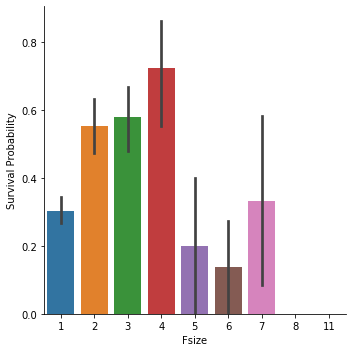

In [22]:
g = sns.catplot(x="Fsize",y="Survived",data = dataset_join, kind='bar')
g = g.set_ylabels("Survival Probability")

In [23]:
# Create new feature of family size
dataset_join['Single'] = dataset_join['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset_join['SmallF'] = dataset_join['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset_join['MedF'] = dataset_join['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset_join['LargeF'] = dataset_join['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [24]:
dataset_join = pd.get_dummies(dataset_join, columns = ['Title'])
dataset_join = pd.get_dummies(dataset_join, columns = ["Embarked"], prefix="Em")


In [25]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset_join["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset_join['Cabin'] ])

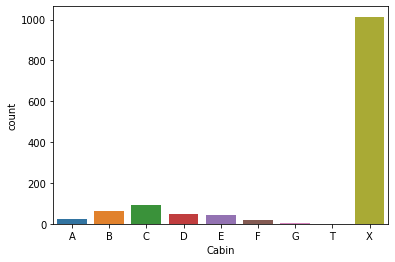

In [26]:
g = sns.countplot(dataset_join["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

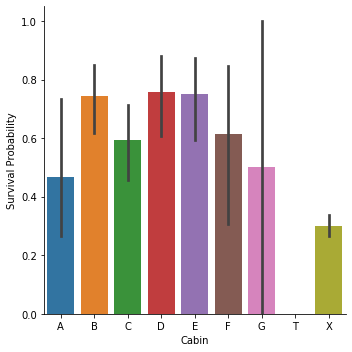

In [27]:
g = sns.catplot(y="Survived",x="Cabin",data=dataset_join,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [28]:
dataset_join = pd.get_dummies(dataset_join, columns = ["Cabin"],prefix="Cabin")

In [29]:
dataset_join["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [30]:
Ticket = []
for i in list(dataset_join.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset_join["Ticket"] = Ticket
dataset_join["Ticket"].head()


0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [31]:
dataset_join = pd.get_dummies(dataset_join, columns = ["Ticket"], prefix="T")

In [32]:
# convert Sex into categorical value 0 for male and 1 for female
# not numerical
dataset_join["Sex"] = dataset_join["Sex"].map({"male": 0, "female":1})

In [33]:
# Create categorical values for Pclass
dataset_join["Pclass"] = dataset_join["Pclass"].astype("category")
dataset_join = pd.get_dummies(dataset_join, columns = ["Pclass"],prefix="Pc")

In [34]:
# Drop useless variables 
dataset_join.drop(labels = ["PassengerId"], axis = 1, inplace = True)
# Drop Name variable
dataset_join.drop(labels = ['Name'], axis = 1, inplace = True)

In [35]:
dataset_join['Age']

0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304    25.0
1305    39.0
1306    38.5
1307    25.0
1308    16.0
Name: Age, Length: 1309, dtype: float64

In [36]:
# dataset_join['CategoricalFare'] = pd.qcut(dataset_join['Fare'], 4)
# dataset_join['CategoricalAge'] = pd.qcut(dataset_join['Age'], 4)

In [37]:
# g = sns.countplot(dataset_join["Has_Cabin"])

In [38]:
# for dataset in full_data:
    
#     # Mapping Fare
#     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
#     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
#     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
#     dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
#     dataset['Fare'] = dataset['Fare'].astype(int)
    
#     # Mapping Age
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [39]:
dataset_join.isnull().sum()

Age      0
Fare     0
Parch    0
Sex      0
SibSp    0
        ..
T_WEP    0
T_X      0
Pc_1     0
Pc_2     0
Pc_3     0
Length: 68, dtype: int64

In [41]:
# # # Feature selection
# # drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
# train = train.drop(drop_elements, axis = 1)
# train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
# test  = test.drop(drop_elements, axis = 1)

In [42]:
## Separate train dataset and test dataset

train = dataset_join[:train_len]
test = dataset_join[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

In [43]:
## Separate train features and label 
# Y_train < label, X_train is take a similar form test dataset

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho

## Visualisations 

In [44]:
train.head(3)

,Age,Fare,Parch,Sex,SibSp,Survived,Name_length,Fsize,Single,SmallF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0,23,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,1,1,1,51,2,0,1,...,0,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,1,0,1,22,1,1,0,...,0,1,0,0,0,0,0,0,0,1


**Pearson Correlation Heatmap**

let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

In [ ]:
# colormap = plt.cm.RdBu
# plt.figure(figsize=(14,12))
# plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0, 
#             square=True, cmap=colormap, linecolor='white', annot=True)

In [46]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        return list(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [47]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [48]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [49]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [65]:
# Modeling step Test differents algorithms 
random_state = SEED
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [66]:
kfold_test = StratifiedKFold(n_splits=10)
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold_test, n_jobs=-1))

In [67]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

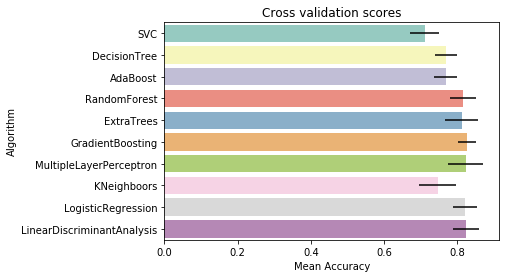

In [68]:

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [70]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold_test, scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_


Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:    3.1s finished


In [71]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold_test, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   42.3s finished


0.8339200998751559

In [72]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold_test, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   47.3s finished


0.832796504369538

In [73]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold_test, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   28.2s finished


0.8283021223470662

In [74]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold_test, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   25.8s finished


0.8305243445692885

In [115]:
train_Survived_RFC = pd.Series(RFC_best.predict(train), name="RFC")
train_Survived_ExtC = pd.Series(ExtC_best.predict(train), name="ExtC")
train_Survived_SVMC = pd.Series(SVMC_best.predict(train), name="SVC")
train_Survived_AdaC = pd.Series(ada_best.predict(train), name="Ada")
train_Survived_GBC = pd.Series(GBC_best.predict(train), name="GBC")
print('!')


test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
print('!')

!
!


pandas.core.series.Series

**Output of the First level Predictions** 

We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [51]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [52]:
rf.feature_importances(x_train, y_train)
rf_features = rf.clf.feature_importances_

et.feature_importances(x_train, y_train)
et_features = et.clf.feature_importances_

ada.feature_importances(x_train, y_train)
ada_features = ada.clf.feature_importances_

gb.feature_importances(x_train, y_train)
gb_features = gb.clf.feature_importances_

[4.66819623e-02 8.87872051e-02 1.37165051e-02 1.54698268e-01
 1.84240570e-02 6.51297673e-02 3.68503805e-02 1.10405483e-02
 7.30202952e-03 1.36104708e-02 1.83543198e-02 1.12555546e-02
 1.22510726e-01 1.54000999e-01 3.18407523e-03 1.20811944e-02
 2.39582022e-03 9.90534737e-03 1.19349077e-03 7.23431739e-03
 4.69488099e-03 4.48539353e-03 8.34449184e-03 1.24702346e-03
 7.85724755e-04 0.00000000e+00 4.17079525e-02 0.00000000e+00
 1.09342367e-04 5.60979587e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.54121206e-05 1.43946798e-03 0.00000000e+00
 0.00000000e+00 4.80557843e-04 0.00000000e+00 3.88702889e-04
 0.00000000e+00 7.59636809e-03 0.00000000e+00 1.13339806e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.28758682e-05
 0.00000000e+00 4.38602670e-04 5.69544119e-05 5.73722359e-04
 0.00000000e+00 8.09502394e-05 1.06405657e-05 5.65683011e-04
 0.00000000e+00 4.48775089e-03 5.31266825e-04 0.00000000e+00
 2.73212522e-03 1.49236489e-03 1.07179007e-04 5.12836965e-03
 4.26772299e-02 1.362799

In [53]:
train.columns.values

array(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Name_length', 'Fsize',
       'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0', 'Title_1',
       'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C',
       'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP',
       'T_PC', 'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH',
       'T_SCOW', 'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP',
       'T_SOTONO2', 'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2',
       'T_STONOQ', 'T_SWPP', 'T_WC', 'T_WEP', 'T_X', 'Pc_1', 'Pc_2',
       'Pc_3'], dtype=object)

In [54]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [55]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Age,0.046682,0.014291,0.150,0.120247,0.082805
1,Fare,0.088787,0.022183,0.440,0.154489,0.176365
2,Parch,0.013717,0.008712,0.032,0.002617,0.014261
3,Sex,0.154698,0.209541,0.016,0.003687,0.095982
4,SibSp,0.018424,0.010918,0.010,0.005850,0.011298
...,...,...,...,...,...,...
62,T_WEP,0.000107,0.000368,0.002,0.000000,0.000619
63,T_X,0.005128,0.005891,0.000,0.003091,0.003527
64,Pc_1,0.042677,0.037088,0.002,0.016627,0.024598
65,Pc_2,0.013628,0.017401,0.000,0.003888,0.008729


**Plotly Barplot of Average Feature Importances**

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [57]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [116]:
np_trAdaC=np.array(train_Survived_AdaC).reshape(-1,1)
np_trExtC=np.array(train_Survived_ExtC).reshape(-1,1)
np_trGBC=np.array(train_Survived_GBC).reshape(-1,1)
np_trRFC=np.array(train_Survived_RFC).reshape(-1,1)
np_trSVMC=np.array(train_Survived_SVMC).reshape(-1,1)

np_tAdaC=np.array(test_Survived_AdaC).reshape(-1,1)
np_tExtC=np.array(test_Survived_ExtC).reshape(-1,1)
np_tGBC=np.array(test_Survived_GBC).reshape(-1,1)
np_tRFC=np.array(test_Survived_RFC).reshape(-1,1)
np_tSVMC=np.array(test_Survived_SVMC).reshape(-1,1)


In [120]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train, np_trAdaC, np_trExtC, np_trGBC, np_trRFC, np_trSVMC), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test, np_tAdaC, np_tExtC, np_tGBC, np_tRFC, np_tSVMC), axis=1)

In [129]:
et_oof_train.shape

(891, 1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [133]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 5000,
 max_depth= 3,
 min_child_weight= 2,
 #gamma=1,
 gamma=1,                        
 subsample=0.8,
 colsample_bytree=0.8,
 # objective= 'binary:logistic', # default value
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [125]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("./result/StackingSubmission0311_2.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.

### Conclusion

I have this notebook has been helpful somewhat in introducing a working script for stacking learning models. Again credit must be extended to Faron and Sina. 

For other excellent material on stacking or ensembling in general, refer to the de-facto Must read article on the website MLWave: [Kaggle Ensembling Guide][1]. 

Till next time, Peace Out

  [1]: http://mlwave.com/kaggle-ensembling-guide/

In [134]:
gbm.score(x_train, y_train)

0.9977553310886644

In [130]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

In [132]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([PassengerId,test_Survived],axis=1)

results.to_csv("ensemble_python_voting0311.csv",index=False)